<a href="https://www.kaggle.com/code/amritarajput54/bigdataprojectheartdisease-ipynb?scriptVersionId=210077553" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
 
import numpy as np  
import pandas as pd  

 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-disease-dataset/heart.csv


In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pyspark: filename=pyspark-3.5.3-py2.py3-none-any.whl size=317840629 sha256=396f055d39406d2b4b0698ea86521313296b9b99b105c1308f44b7dcae0d7d8c
  Stored in directory: /root/.cache/pip/wheels/1b/3a/92/28b93e2fbfdbb07509ca4d6f50c5e407f48dce4ddbda69a4ab
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col
import pandas as pd
spark = SparkSession.builder.appName("HeartDiseasePrediction").getOrCreate()
data = spark.read.csv("/kaggle/input/heart-disease-dataset/heart.csv", header=True, inferSchema=True)
data.printSchema()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/28 08:44:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)



In [4]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
data = data.withColumnRenamed("cp", "chest_pain_type") \
           .withColumnRenamed("trestbps", "resting_bp") \
           .withColumnRenamed("chol", "cholesterol") \
           .withColumnRenamed("fbs", "fasting_blood_sugar") \
           .withColumnRenamed("restecg", "rest_ecg") \
           .withColumnRenamed("thalach", "max_heart_rate") \
           .withColumnRenamed("exang", "exercise_angina") \
           .withColumnRenamed("oldpeak", "st_depression") \
           .withColumnRenamed("ca", "num_major_vessels")
data = data.fillna({
    "cholesterol": data.select("cholesterol").dropna().rdd.map(lambda x: x[0]).mean(),
    "thal": data.groupBy("thal").count().orderBy("count", ascending=False).first()["thal"]
})
indexers = [
    StringIndexer(inputCol="sex", outputCol="sex_indexed"),
    StringIndexer(inputCol="chest_pain_type", outputCol="chest_pain_type_indexed"),
    StringIndexer(inputCol="rest_ecg", outputCol="rest_ecg_indexed"),
    StringIndexer(inputCol="thal", outputCol="thal_indexed")
]

for indexer in indexers:
    data = indexer.fit(data).transform(data)
data = data.withColumn("cholesterol_age_ratio", col("cholesterol") / col("age"))
feature_cols = ["age", "sex_indexed", "chest_pain_type_indexed", "resting_bp", "cholesterol",
                "max_heart_rate", "exercise_angina", "st_depression", "num_major_vessels",
                "thal_indexed", "cholesterol_age_ratio"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(data)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)
final_data = data.select(col("scaled_features").alias("features"), col("target").alias("label"))


In [5]:
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)
lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_data)
rf = RandomForestClassifier(featuresCol="features", labelCol="label")
rf_model = rf.fit(train_data)


24/11/28 08:45:01 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [6]:
lr_predictions = lr_model.transform(test_data)
rf_predictions = rf_model.transform(test_data)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
lr_auc = evaluator.evaluate(lr_predictions)
rf_auc = evaluator.evaluate(rf_predictions)

print(f"Logistic Regression AUC: {lr_auc}")
print(f"Random Forest AUC: {rf_auc}")

lr_predictions.groupBy("label", "prediction").count().show()
rf_predictions.groupBy("label", "prediction").count().show()


Logistic Regression AUC: 0.9207865168539328
Random Forest AUC: 0.976685393258427
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   13|
|    0|       0.0|   68|
|    1|       1.0|   76|
|    0|       1.0|   12|
+-----+----------+-----+

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    7|
|    0|       0.0|   72|
|    1|       1.0|   82|
|    0|       1.0|    8|
+-----+----------+-----+



[08:45:14] task 0 got new rank 0
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:45:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "maxDepth", "numRound" } are not used.

  warnings.warn(smsg, UserWarning)


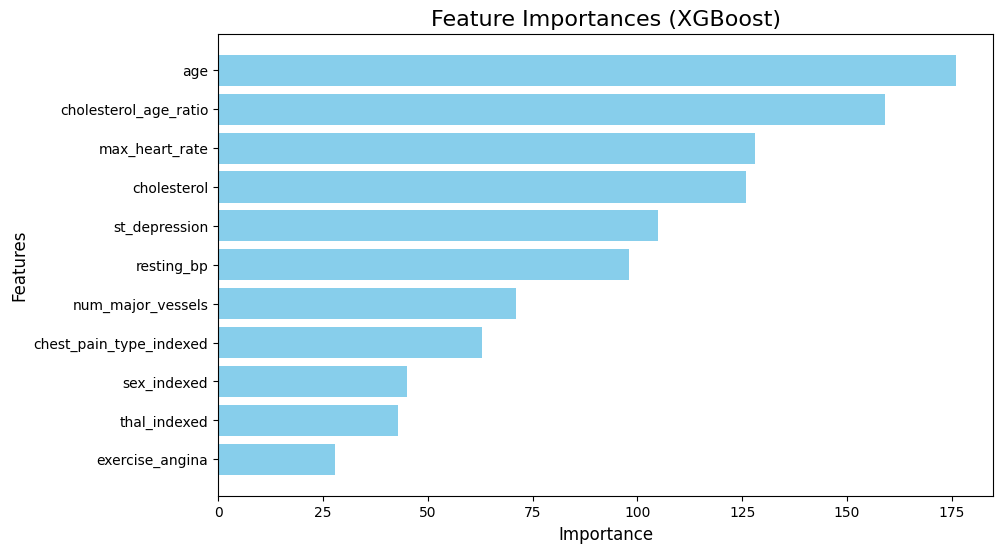

In [7]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd
 
feature_cols = ["age", "sex_indexed", "chest_pain_type_indexed", "resting_bp", "cholesterol",
                "max_heart_rate", "exercise_angina", "st_depression", "num_major_vessels",
                "thal_indexed", "cholesterol_age_ratio"]
 
 
from xgboost.spark import SparkXGBClassifier

xgb = SparkXGBClassifier(label_col="label", features_col="features", numRound=10, maxDepth=5)
xgb_model = xgb.fit(train_data)
 
booster = xgb_model.get_booster()  # Access the underlying XGBoost Booster
feature_importances = booster.get_score(importance_type='weight')  # 'weight' importance type (default)
 
feature_importance_df = pd.DataFrame(list(feature_importances.items()), columns=["Feature", "Importance"])
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
 
feature_mapping = {f"f{i}": col for i, col in enumerate(feature_cols)}
feature_importance_df["Feature"] = feature_importance_df["Feature"].map(feature_mapping)
 
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color='skyblue')
plt.title("Feature Importances (XGBoost)", fontsize=16)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()



In [8]:
from pyspark.sql.functions import col

# Count instances in each class (target column)
class_counts = data.groupBy("target").count().collect()
minority_class_count = min(row['count'] for row in class_counts)
majority_class_label = max(class_counts, key=lambda row: row['count'])['target']

# Separate the classes
minority_class = data.filter(col("target") != majority_class_label)
majority_class = data.filter(col("target") == majority_class_label)

# Undersample the majority class
undersampled_majority_class = majority_class.sample(fraction=minority_class_count / majority_class.count())

# Combine the balanced dataset
balanced_df = minority_class.union(undersampled_majority_class)

# Validate the balanced dataset
balanced_df.groupBy("target").count().show()


+------+-----+
|target|count|
+------+-----+
|     0|  499|
|     1|  495|
+------+-----+



In [9]:
predictions = xgb_model.transform(test_data)
 
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)
 
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)
 
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
recall = recall_evaluator.evaluate(predictions)
 
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_score = f1_evaluator.evaluate(predictions)
 
roc_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = roc_evaluator.evaluate(predictions)
 
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

param_grid = ParamGridBuilder().build()  # Add hyperparameters if needed
crossval = CrossValidator(estimator=xgb, 
                          estimatorParamMaps=param_grid, 
                          evaluator=BinaryClassificationEvaluator(labelCol="label"), 
                          numFolds=5)
cv_model = crossval.fit(train_data)
print(f"Cross-validated performance: {cv_model.avgMetrics[0]:.4f}")


Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
ROC AUC: 1.0000


[08:45:22] task 0 got new rank 0
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:45:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "maxDepth", "numRound" } are not used.

  warnings.warn(smsg, UserWarning)
[08:45:26] task 0 got new rank 0
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:45:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "maxDepth", "numRound" } are not used.

  warnings.warn(smsg, UserWarning)
[08:45:30] task 0 got new rank 0
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:45:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "maxDepth", "numRound" } are not used.

  warnings.warn(smsg, UserWarning)
[08:45:34] task 0 got new rank 0
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [08:45:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "maxDepth", "numRound" } are not used.

  warnings.warn(smsg, UserWarning)
[08:45:3

Cross-validated performance: 0.9965


In [10]:
print(f"Best model parameters: {cv_model.bestModel.extractParamMap()}")


Best model parameters: {Param(parent='SparkXGBClassifier_6d9e60eedf9f', name='enable_sparse_data_optim', doc='This stores the boolean config of enabling sparse data optimization, if enabled, Xgboost DMatrix object will be constructed from sparse matrix instead of dense matrix. This config is disabled by default. If most of examples in your training dataset contains sparse features, we suggest to enable this config.'): False, Param(parent='SparkXGBClassifier_6d9e60eedf9f', name='featuresCol', doc='features column name.'): 'features', Param(parent='SparkXGBClassifier_6d9e60eedf9f', name='features_cols', doc='feature column names.'): [], Param(parent='SparkXGBClassifier_6d9e60eedf9f', name='labelCol', doc='label column name.'): 'label', Param(parent='SparkXGBClassifier_6d9e60eedf9f', name='predictionCol', doc='prediction column name.'): 'prediction', Param(parent='SparkXGBClassifier_6d9e60eedf9f', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note:

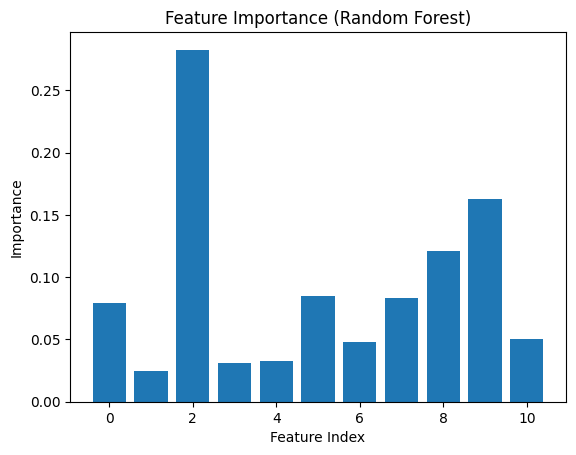

In [11]:
import matplotlib.pyplot as plt
 
rf_importances = rf_model.featureImportances
x_values = list(range(len(rf_importances)))
plt.bar(x_values, rf_importances)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importance (Random Forest)")
plt.show()


In [12]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
 
multi_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
binary_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction")
 
def evaluate_classification_model(predictions, model_name):
    accuracy = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "accuracy"})
    precision = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedPrecision"})
    recall = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "weightedRecall"})
    f1 = multi_evaluator.evaluate(predictions, {multi_evaluator.metricName: "f1"})
    roc_auc = binary_evaluator.evaluate(predictions)
    
    return {
        "Model Name": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC": roc_auc
    }
 
lr_predictions = lr_model.transform(test_data)
lr_metrics = evaluate_classification_model(lr_predictions, "Logistic Regression")
 
rf_predictions = rf_model.transform(test_data)
rf_metrics = evaluate_classification_model(rf_predictions, "Random Forest")
 
classification_results = [lr_metrics, rf_metrics]

# Print the results
for result in classification_results:
    print(result)


{'Model Name': 'Logistic Regression', 'Accuracy': 0.8520710059171598, 'Precision': 0.852213788111224, 'Recall': 0.8520710059171598, 'F1-Score': 0.8521125342167233, 'ROC': 0.9207865168539328}
{'Model Name': 'Random Forest', 'Accuracy': 0.9112426035502958, 'Precision': 0.9112442680115513, 'Recall': 0.9112426035502958, 'F1-Score': 0.9112114179291126, 'ROC': 0.976685393258427}


In [13]:
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier, MultilayerPerceptronClassifier
 
dt_classifier = DecisionTreeClassifier(featuresCol="features", labelCol="label")
dt_model = dt_classifier.fit(train_data)
dt_predictions = dt_model.transform(test_data)
dt_metrics = evaluate_classification_model(dt_predictions, "Decision Tree")
 
gbt_classifier = GBTClassifier(featuresCol="features", labelCol="label", maxIter=20)
gbt_model = gbt_classifier.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)
gbt_metrics = evaluate_classification_model(gbt_predictions, "Gradient-Boosted Tree")
 
layers = [len(feature_cols), 8, 4, 2]  # Input layer, hidden layers, and output layer
mlp_classifier = MultilayerPerceptronClassifier(featuresCol="features", labelCol="label", layers=layers, maxIter=100)
mlp_model = mlp_classifier.fit(train_data)
mlp_predictions = mlp_model.transform(test_data)
mlp_metrics = evaluate_classification_model(mlp_predictions, "Multilayer Perceptron")
 
classification_results.extend([dt_metrics, gbt_metrics, mlp_metrics])
 
for result in classification_results:
    print(result)


{'Model Name': 'Logistic Regression', 'Accuracy': 0.8520710059171598, 'Precision': 0.852213788111224, 'Recall': 0.8520710059171598, 'F1-Score': 0.8521125342167233, 'ROC': 0.9207865168539328}
{'Model Name': 'Random Forest', 'Accuracy': 0.9112426035502958, 'Precision': 0.9112442680115513, 'Recall': 0.9112426035502958, 'F1-Score': 0.9112114179291126, 'ROC': 0.976685393258427}
{'Model Name': 'Decision Tree', 'Accuracy': 0.9171597633136095, 'Precision': 0.9171597633136095, 'Recall': 0.9171597633136095, 'F1-Score': 0.9171597633136095, 'ROC': 0.9253511235955056}
{'Model Name': 'Gradient-Boosted Tree', 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1-Score': 1.0, 'ROC': 1.0}
{'Model Name': 'Multilayer Perceptron', 'Accuracy': 0.8579881656804734, 'Precision': 0.8583680450148716, 'Recall': 0.8579881656804733, 'F1-Score': 0.858057896519435, 'ROC': 0.9255617977528093}


In [14]:
from pyspark.ml.evaluation import RegressionEvaluator
 
reg_evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")
 
def evaluate_regression_model(predictions, model_name):
    rmse = reg_evaluator.evaluate(predictions, {reg_evaluator.metricName: "rmse"})
    mse = reg_evaluator.evaluate(predictions, {reg_evaluator.metricName: "mse"})
    mae = reg_evaluator.evaluate(predictions, {reg_evaluator.metricName: "mae"})
    r2 = reg_evaluator.evaluate(predictions, {reg_evaluator.metricName: "r2"})
    mape = predictions.selectExpr("abs(label - prediction)/label as ape").agg({"ape": "avg"}).collect()[0][0] * 100
    
    return {
        "Model Name": model_name,
        "RMSE": rmse,
        "MSE": mse,
        "MAE": mae,
        "R-squared": r2,
        "MAPE": mape
    }
 
from pyspark.ml.regression import LinearRegression

lr_regressor = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr_regressor.fit(train_data)
lr_predictions = lr_model.transform(test_data)
lr_regression_metrics = evaluate_regression_model(lr_predictions, "Linear Regression")
 
regression_results = [lr_regression_metrics]
 
for result in regression_results:
    print(result)


24/11/28 08:46:02 WARN Instrumentation: [1054fe81] regParam is zero, which might cause numerical instability and overfitting.
24/11/28 08:46:02 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


{'Model Name': 'Linear Regression', 'RMSE': 0.34464679755452704, 'MSE': 0.11878141506459114, 'MAE': 0.27115824851727083, 'R-squared': 0.5235230343174455, 'MAPE': 27.427104437349136}


In [15]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import IsotonicRegression, GeneralizedLinearRegression
 
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
train_scaled = scaler.fit(train_data).transform(train_data)
test_scaled = scaler.fit(test_data).transform(test_data)
 
iso_regressor = IsotonicRegression(featuresCol="scaledFeatures", labelCol="label", isotonic=True)
iso_model = iso_regressor.fit(train_scaled)
iso_predictions = iso_model.transform(test_scaled)
iso_regression_metrics = evaluate_regression_model(iso_predictions, "Isotonic Regression")
 
glr_regressor = GeneralizedLinearRegression(featuresCol="scaledFeatures", labelCol="label", family="gaussian", link="identity", regParam=0.01)
glr_model = glr_regressor.fit(train_scaled)
glr_predictions = glr_model.transform(test_scaled)
glr_regression_metrics = evaluate_regression_model(glr_predictions, "Generalized Linear Regression")


dt_regression_metrics = evaluate_regression_model(dt_predictions, "dt")
lr_regression_metrics = evaluate_regression_model(lr_predictions, "lr")
rf_regression_metrics = evaluate_regression_model(rf_predictions, "rf")

gbt_regression_metrics = evaluate_regression_model(gbt_predictions, "rf")

mlp_regression_metrics = evaluate_regression_model(mlp_predictions, "rf")


In [16]:
import numpy as np
from pyspark.ml.linalg import DenseVector
 
def convert_to_numpy(dataframe):
    features = np.array([np.array(row['features'].toArray()) for row in dataframe.collect()])
    labels = np.array([row['label'] for row in dataframe.collect()])
    return features, labels
 
train_features, train_labels = convert_to_numpy(train_data)
test_features, test_labels = convert_to_numpy(test_data)
 
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(len(feature_cols),)),  # Input shape based on number of features
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer for regression
])
 
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
 
model.fit(train_features, train_labels, epochs=20, batch_size=32, validation_split=0.2)
 
test_loss, test_mae = model.evaluate(test_features, test_labels)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.8331 - mae: 1.1256 - val_loss: 0.3513 - val_mae: 0.4878
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3045 - mae: 0.4443 - val_loss: 0.2650 - val_mae: 0.4206
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2150 - mae: 0.3720 - val_loss: 0.2242 - val_mae: 0.3773
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1773 - mae: 0.3350 - val_loss: 0.2068 - val_mae: 0.3497
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1510 - mae: 0.3045 - val_loss: 0.1924 - val_mae: 0.3379
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1181 - mae: 0.2617 - val_loss: 0.1867 - val_mae: 0.3303
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1262 - mae: 0.2700 - val_loss: 0.1940 - val_mae: 0.3408
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1176 - mae: 0.2664 - val_loss: 0.2127 - val_mae: 0.3554
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1125 - mae:

In [17]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import IsotonicRegression, GeneralizedLinearRegression
 
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
train_scaled = scaler.fit(train_data).transform(train_data)
test_scaled = scaler.fit(test_data).transform(test_data)
 
iso_regressor = IsotonicRegression(featuresCol="scaledFeatures", labelCol="label", isotonic=True)
iso_model = iso_regressor.fit(train_scaled)
iso_predictions = iso_model.transform(test_scaled)
iso_regression_metrics = evaluate_regression_model(iso_predictions, "Isotonic Regression")
print("Isotonic Regression Metrics:", iso_regression_metrics)
 
glr_regressor = GeneralizedLinearRegression(featuresCol="scaledFeatures", labelCol="label", family="gaussian", link="identity", regParam=0.01)
glr_model = glr_regressor.fit(train_scaled)
glr_predictions = glr_model.transform(test_scaled)
glr_regression_metrics = evaluate_regression_model(glr_predictions, "Generalized Linear Regression")
print("Generalized Linear Regression Metrics:", glr_regression_metrics)

print("dt Metrics:", dt_regression_metrics)
print("lr Metrics:", lr_regression_metrics)
print("rf Metrics:", rf_regression_metrics)
print("gbt Metrics:", gbt_regression_metrics)
print("mlp Metrics:", mlp_regression_metrics)



Isotonic Regression Metrics: {'Model Name': 'Isotonic Regression', 'RMSE': 0.4967102466259371, 'MSE': 0.24672106910319924, 'MAE': 0.4959692435995373, 'R-squared': 0.010308924907798556, 'MAPE': 48.75364082827924}
Generalized Linear Regression Metrics: {'Model Name': 'Generalized Linear Regression', 'RMSE': 0.34340366213111906, 'MSE': 0.11792607516506376, 'MAE': 0.26816772757026375, 'R-squared': 0.5269541246082323, 'MAPE': 26.18080423813617}
dt Metrics: {'Model Name': 'dt', 'RMSE': 0.2878197989826109, 'MSE': 0.08284023668639054, 'MAE': 0.08284023668639054, 'R-squared': 0.6676966292134832, 'MAPE': 7.865168539325842}
lr Metrics: {'Model Name': 'lr', 'RMSE': 0.34464679755452704, 'MSE': 0.11878141506459114, 'MAE': 0.27115824851727083, 'R-squared': 0.5235230343174455, 'MAPE': 27.427104437349136}
rf Metrics: {'Model Name': 'rf', 'RMSE': 0.297921795862109, 'MSE': 0.08875739644970415, 'MAE': 0.08875739644970414, 'R-squared': 0.6439606741573033, 'MAPE': 7.865168539325842}
gbt Metrics: {'Model Nam

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
 
sns.set(style="whitegrid")
 


In [19]:
pandas_df = data.toPandas()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


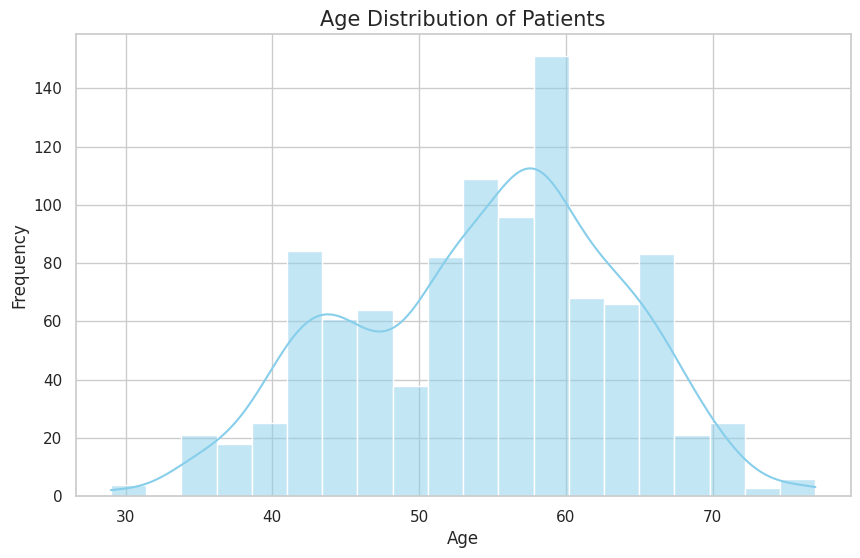

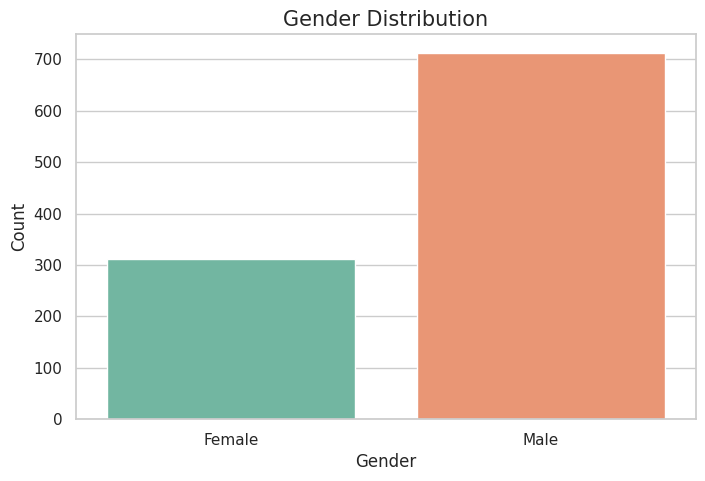

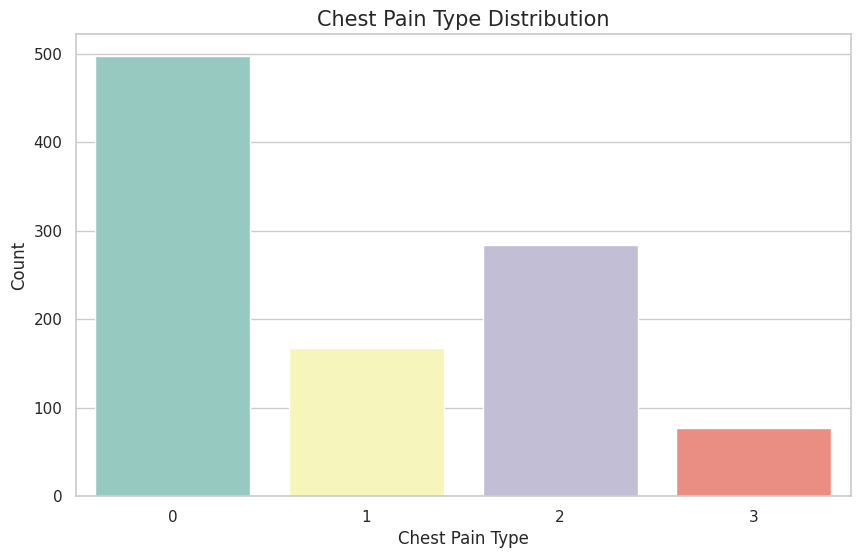

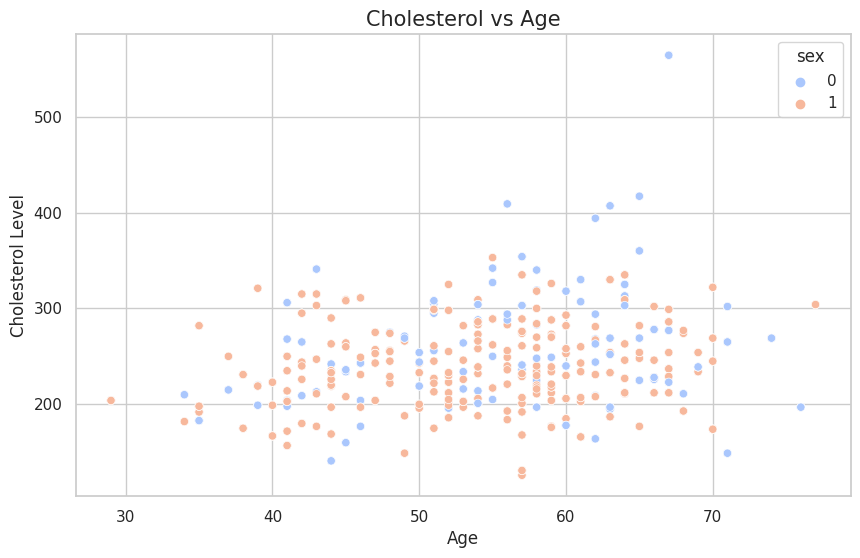

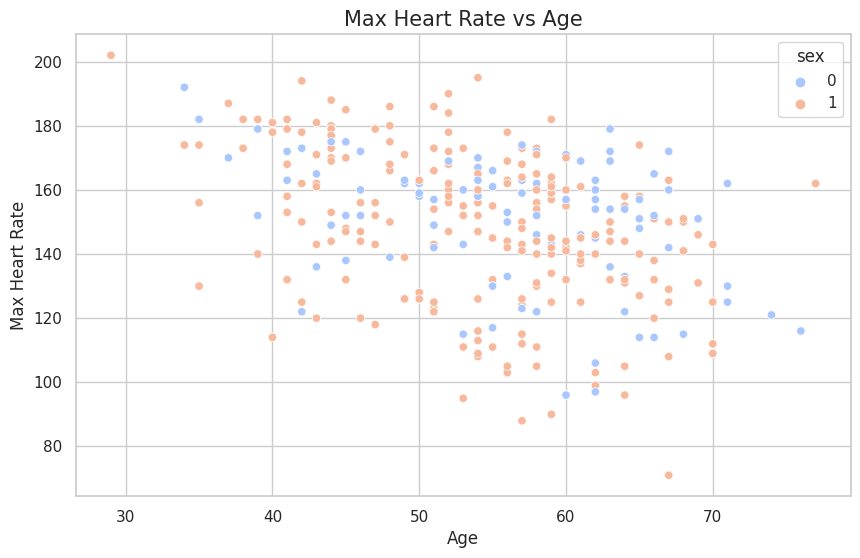

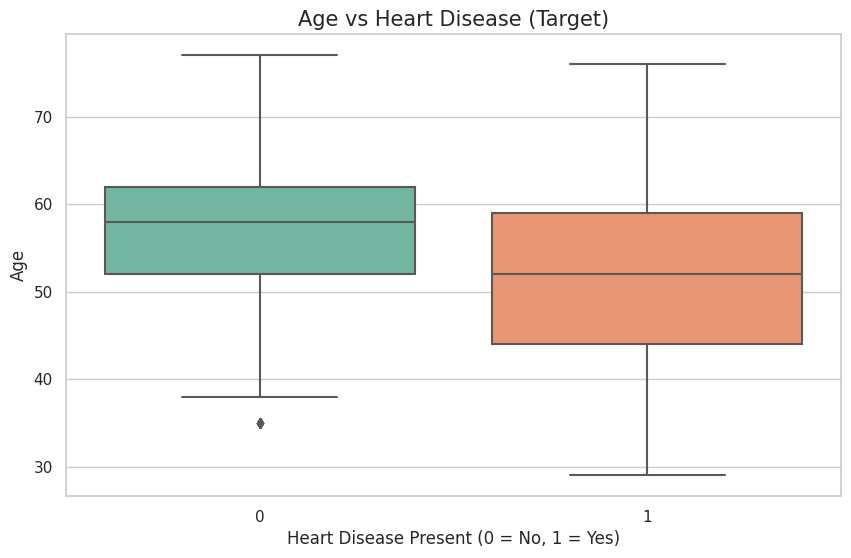

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


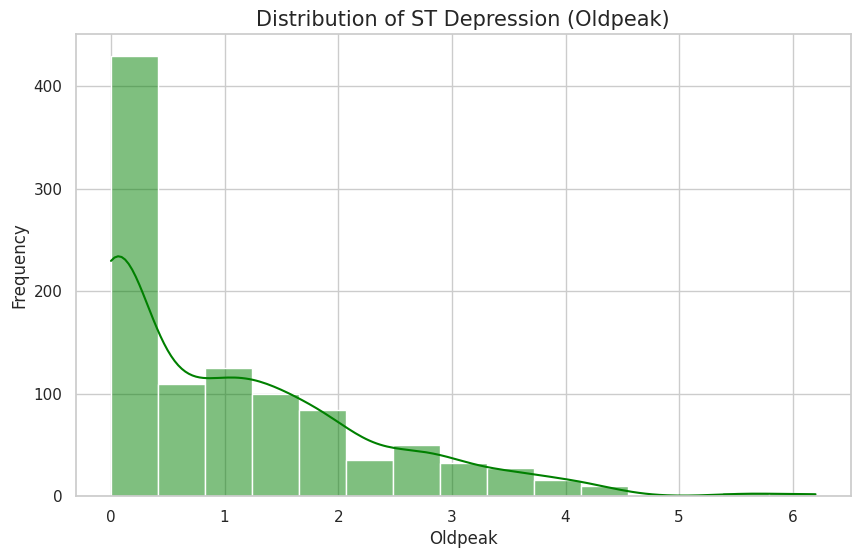

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated a

<Figure size 1200x1000 with 0 Axes>

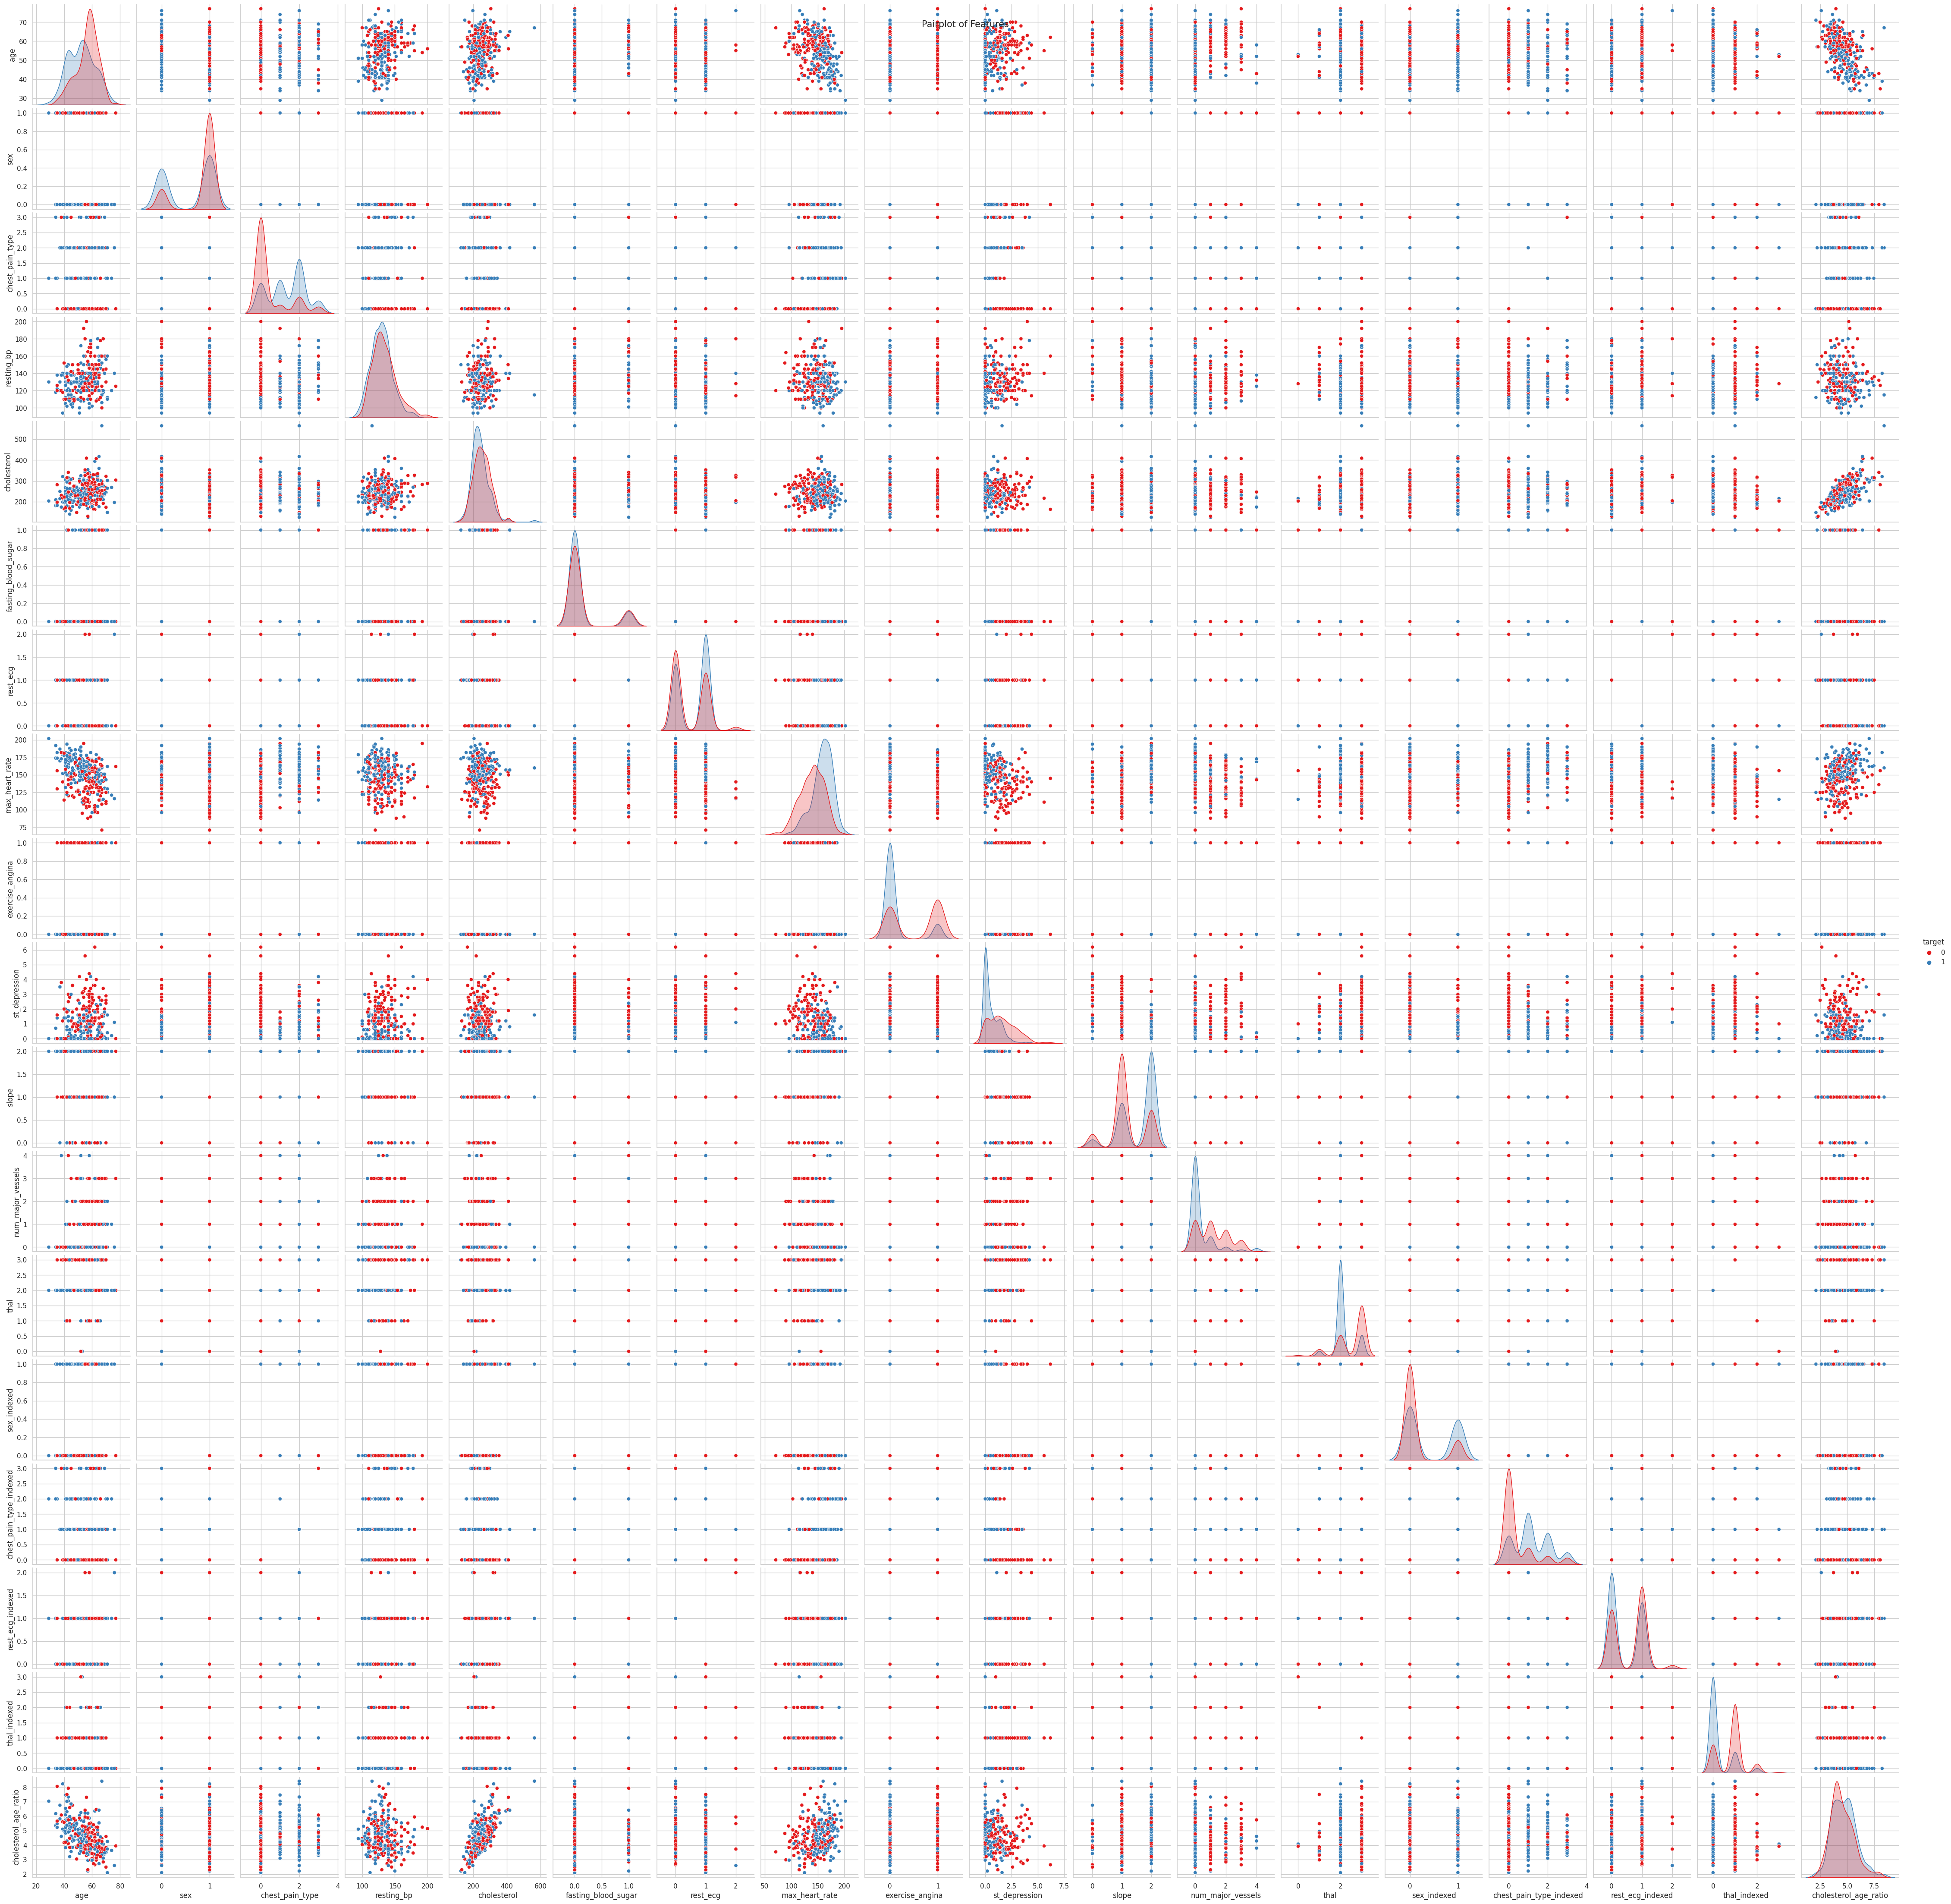

In [20]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col
plt.figure(figsize=(10, 6))
sns.histplot(pandas_df['age'], kde=True, color='skyblue', bins=20)
plt.title('Age Distribution of Patients', fontsize=15)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()
 
plt.figure(figsize=(8, 5))
sns.countplot(x='sex', data=pandas_df, palette='Set2')
plt.title('Gender Distribution', fontsize=15)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Female', 'Male'])
plt.show()
 
plt.figure(figsize=(10, 6))
sns.countplot(x='chest_pain_type', data=pandas_df, palette='Set3')
plt.title('Chest Pain Type Distribution', fontsize=15)
plt.xlabel('Chest Pain Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

 
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='cholesterol', data=pandas_df, hue='sex', palette='coolwarm')
plt.title('Cholesterol vs Age', fontsize=15)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Cholesterol Level', fontsize=12)
plt.show()

# 6. Max Heart Rate vs Age
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='max_heart_rate', data=pandas_df, hue='sex', palette='coolwarm')
plt.title('Max Heart Rate vs Age', fontsize=15)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Max Heart Rate', fontsize=12)
plt.show()

# 7. Boxplot for Age and Target Variable (Heart Disease)
plt.figure(figsize=(10, 6))
sns.boxplot(x='target', y='age', data=pandas_df, palette='Set2')
plt.title('Age vs Heart Disease (Target)', fontsize=15)
plt.xlabel('Heart Disease Present (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Age', fontsize=12)
plt.show()

# 8. Distribution of St Depression (oldpeak)
plt.figure(figsize=(10, 6))
sns.histplot(pandas_df['st_depression'], kde=True, color='green', bins=15)
plt.title('Distribution of ST Depression (Oldpeak)', fontsize=15)
plt.xlabel('Oldpeak', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# 9. Pairplot for All Numeric Features
plt.figure(figsize=(12, 10))
sns.pairplot(pandas_df, hue='target', palette='Set1', diag_kind='kde')
plt.suptitle('Pairplot of Features', fontsize=15)
plt.show()

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import numpy as np
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Estimator

def plot_roc_curve_and_confusion_matrix(model, test_data, model_name="Model", plot_roc=True, plot_confusion_matrix=True):
    """
    Function to plot ROC curve and confusion matrix for a given model.
    
    Parameters:
    model (Estimator): The trained model
    test_data (DataFrame): The test dataset
    model_name (str): Name of the model (for title in plots)
    plot_roc (bool): If True, plot ROC curve
    plot_confusion_matrix (bool): If True, plot confusion matrix heatmap
    """
     
    predictions = model.transform(test_data)
 
    prob = predictions.select("probability").rdd.map(lambda row: row[0][1]).collect()
    true_labels = predictions.select("label").rdd.map(lambda row: row[0]).collect()
    
    # ROC Curve
    if plot_roc:
        fpr, tpr, thresholds = roc_curve(true_labels, prob)
        auc_score = roc_auc_score(true_labels, prob)
        
        plt.figure(figsize=(10, 6))
        plt.plot(fpr, tpr, color='blue', label=f'{model_name} (AUC = {auc_score:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc="lower right")
        plt.show()

    # Confusion Matrix Heatmap
    if plot_confusion_matrix:
        cm = confusion_matrix(true_labels, [1 if p >= 0.5 else 0 for p in prob])
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
        plt.title(f'Confusion Matrix - {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()


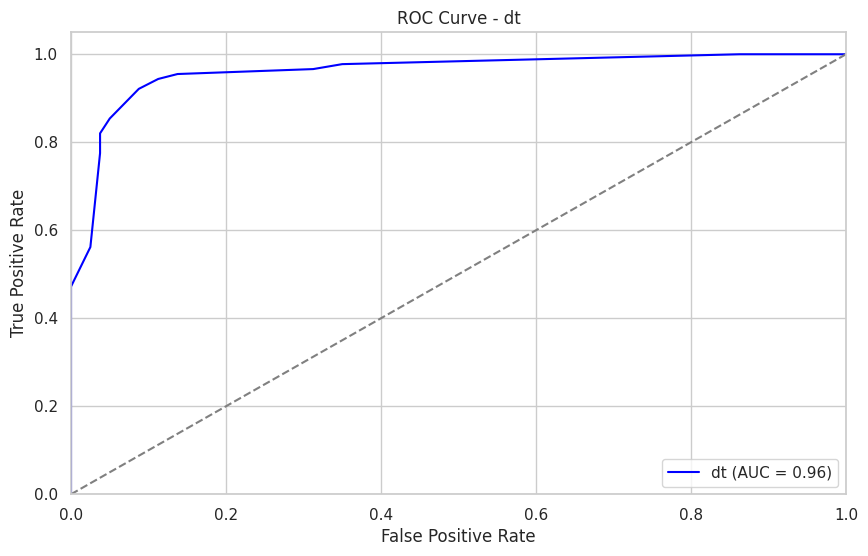

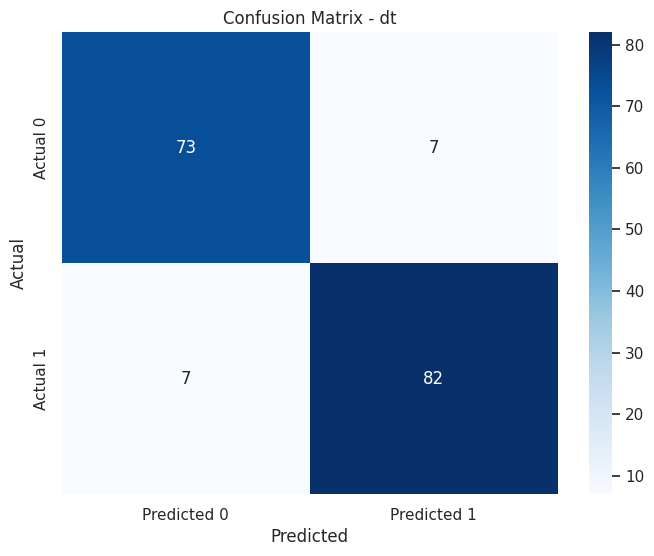

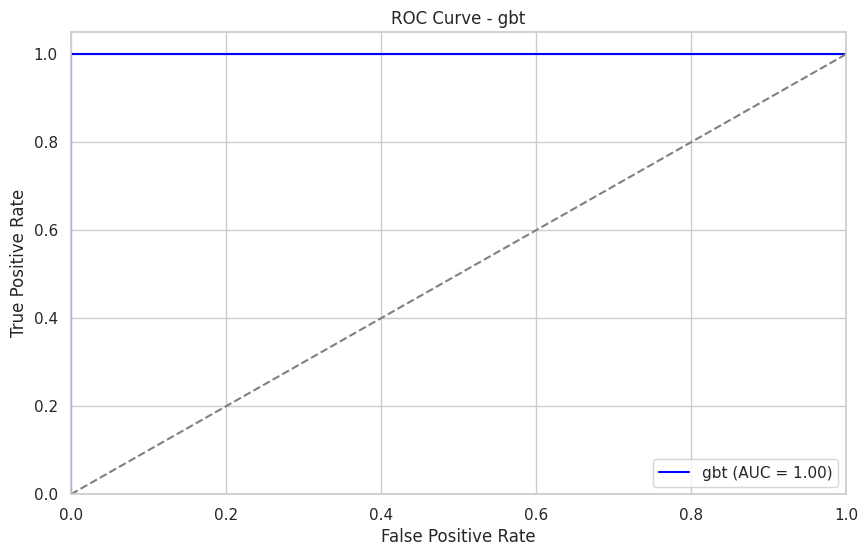

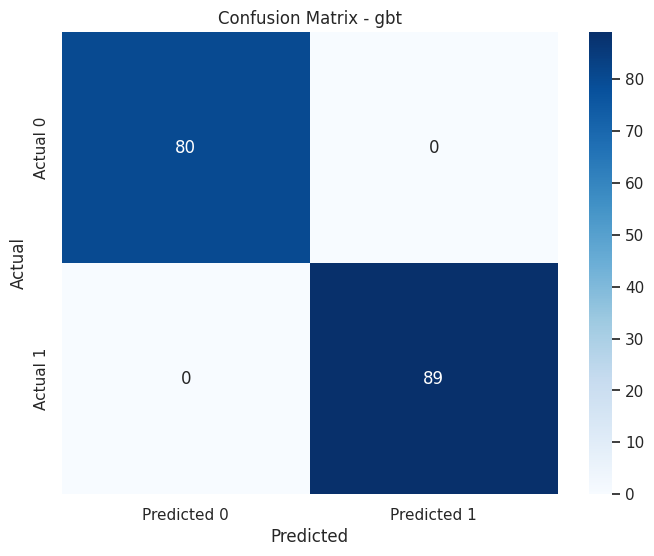

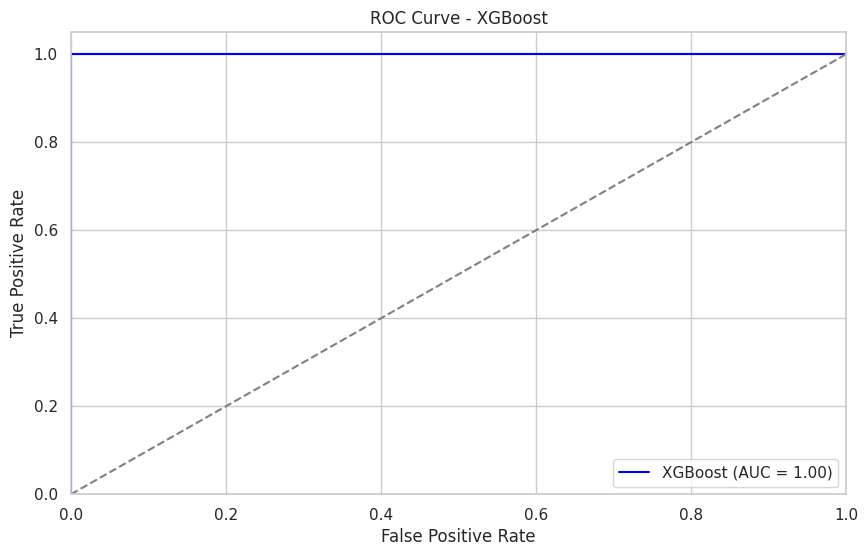

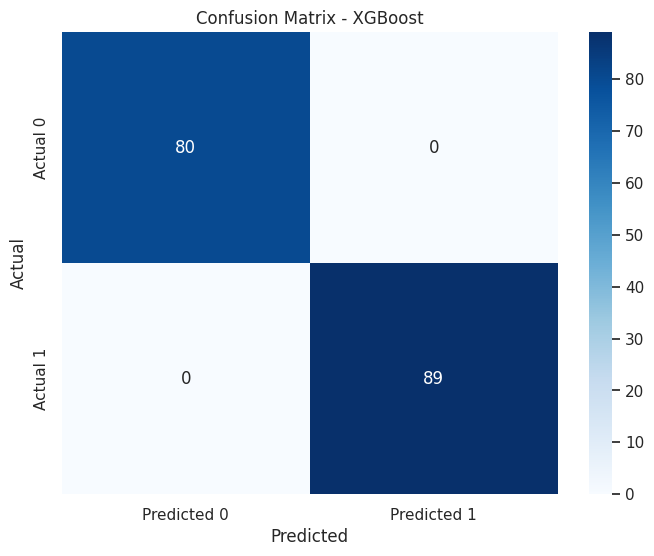

In [22]:
# Example for Logistic Regression Model
plot_roc_curve_and_confusion_matrix(dt_model, test_data, model_name="dt")

# Example for Random Forest Model
plot_roc_curve_and_confusion_matrix(gbt_model, test_data, model_name="gbt")

# Example for XGBoost Model
plot_roc_curve_and_confusion_matrix(xgb_model, test_data, model_name="XGBoost")


In [23]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row

# Create the widget input fields for each feature
age = widgets.IntText(value=50, description='Age:')
sex = widgets.Dropdown(options=[0, 1], value=1, description='Sex:', disabled=False)
cp = widgets.Dropdown(options=[0, 1, 2, 3], value=1, description='CP:', disabled=False)
trestbps = widgets.IntText(value=120, description='Trestbps:')
chol = widgets.IntText(value=240, description='Cholesterol:')
fbs = widgets.Dropdown(options=[0, 1], value=0, description='FBS:', disabled=False)
restecg = widgets.Dropdown(options=[0, 1, 2], value=0, description='Restecg:', disabled=False)
thalach = widgets.IntText(value=150, description='Thalach:')
exang = widgets.Dropdown(options=[0, 1], value=0, description='Exang:', disabled=False)
oldpeak = widgets.FloatText(value=1.0, description='Oldpeak:')
slope = widgets.Dropdown(options=[0, 1, 2], value=1, description='Slope:', disabled=False)
ca = widgets.IntText(value=0, description='CA:')
thal = widgets.Dropdown(options=[0, 1, 2, 3], value=2, description='Thal:', disabled=False)

# Display widgets for user input
display(age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal)

# Function to predict heart disease
def predict_heart_disease(*args):
    # Get feature values from the widgets
    input_features = [
        age.value, sex.value, cp.value, trestbps.value, chol.value, fbs.value,
        restecg.value, thalach.value, exang.value, oldpeak.value, slope.value, ca.value, thal.value
    ]
    
    # Create a DenseVector for features
    features_vector = Vectors.dense(input_features)
    
    # Create a Row object with the features
    row = Row(features=features_vector)
    input_df = spark.createDataFrame([row])
    
    
    
    # Get the prediction values (Assuming 'prediction' column exists in the output)
    lr_pred = lr_prediction.select("prediction").first()[0]
    rf_pred = rf_prediction.select("prediction").first()[0]
    xgb_pred = xgb_prediction.select("prediction").first()[0]
    
    # Display predictions
    print(f"Logistic Regression Prediction: {'Heart Disease' if lr_pred == 1 else 'No Heart Disease'}")
    print(f"Random Forest Prediction: {'Heart Disease' if rf_pred == 1 else 'No Heart Disease'}")
    print(f"XGBoost Prediction: {'Heart Disease' if xgb_pred == 1 else 'No Heart Disease'}")

# Link the widgets to the prediction function
for widget in [age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal]:
    widget.observe(predict_heart_disease, names='value')


IntText(value=50, description='Age:')

Dropdown(description='Sex:', index=1, options=(0, 1), value=1)

Dropdown(description='CP:', index=1, options=(0, 1, 2, 3), value=1)

IntText(value=120, description='Trestbps:')

IntText(value=240, description='Cholesterol:')

Dropdown(description='FBS:', options=(0, 1), value=0)

Dropdown(description='Restecg:', options=(0, 1, 2), value=0)

IntText(value=150, description='Thalach:')

Dropdown(description='Exang:', options=(0, 1), value=0)

FloatText(value=1.0, description='Oldpeak:')

Dropdown(description='Slope:', index=1, options=(0, 1, 2), value=1)

IntText(value=0, description='CA:')

Dropdown(description='Thal:', index=2, options=(0, 1, 2, 3), value=2)

In [24]:
# End the Spark session
spark.stop()
